In [ ]:
# import libraries
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 , ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Get the data from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedsayed1832","key":"713e5f12f6f65b25174683f0acc517d3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 99% 1.51G/1.52G [00:09<00:00, 209MB/s]
100% 1.52G/1.52G [00:09<00:00, 179MB/s]


In [ ]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [ ]:
df = pd.read_csv('/content/kidneyData.csv')
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


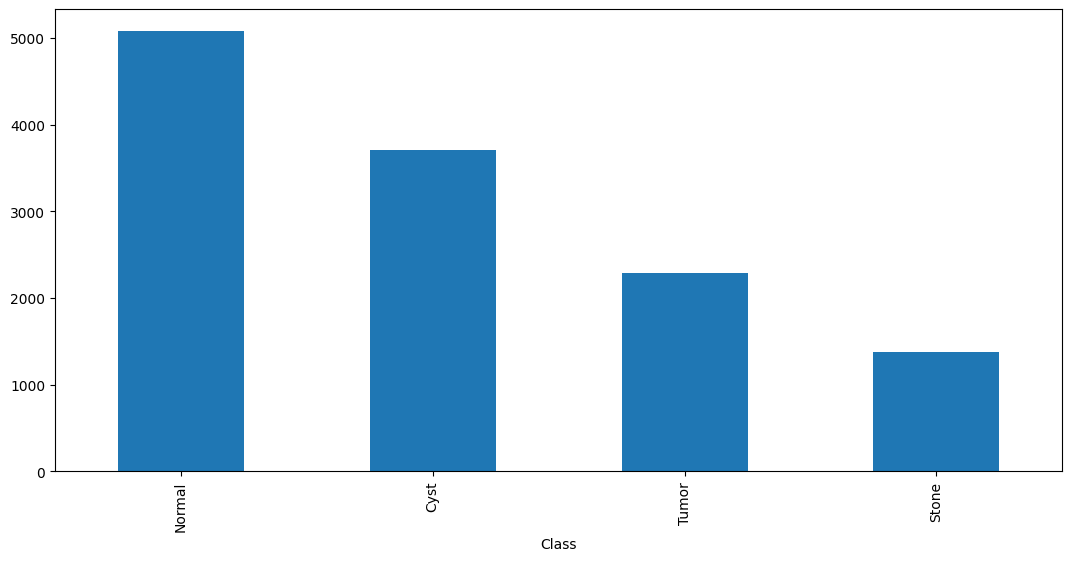

In [ ]:
plt.figure(figsize=(13,6))
df['Class'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
import os
import shutil

# The original path of repeated data
base_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# The new track to store images after cleaning
cleaned_dir = '/content/cleaned_dataset'

# Create the new folder if it does not exist
os.makedirs(cleaned_dir, exist_ok=True)

# I walk on every class
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Folder created for the new class
    new_class_path = os.path.join(cleaned_dir, class_name)
    os.makedirs(new_class_path, exist_ok=True)

    # Collect the Images and sort them
    images = sorted(os.listdir(class_path))

    # Store the number of pictures that you took
    selected_count = 0

    for idx, img_name in enumerate(images):
        if idx % 10 == 0:  # Take one image every 15
            src_img = os.path.join(class_path, img_name)
            dst_img = os.path.join(new_class_path, img_name)
            shutil.copy(src_img, dst_img)
            selected_count += 1

    print(f"✅ {class_name}: Select {selected_count} image from {len(images)}")

print("🎉 Done filtering duplicate-style images.")


✅ Tumor: Select 229 image from 2283
✅ Normal: Select 508 image from 5077
✅ Cyst: Select 371 image from 3709
✅ Stone: Select 138 image from 1377
🎉 Done filtering duplicate-style images.


## 🔍 Dataset Cleaning Strategy: Reducing Redundancy

During initial data inspection, we observed that the dataset contained **highly redundant images** — especially due to prior **data augmentation**. For example, images named `Cyst_1.png` to `Cyst_15.png` were nearly identical, repeated up to 10-15 times with slight variations.

### ⚠️ Why This is a Problem?
- **Overfitting Risk:** Models may learn to memorize images instead of learning general features.
- **Misleading Validation Accuracy:** Duplicates can appear in both training and validation sets, giving false impressions of performance.
- **Poor Generalization:** The model struggles when exposed to real-world images (e.g., from Google) that were not seen in training.

### ✅ Our Solution
To mitigate this, we applied a **simple yet effective filtering approach**:
- For every 10 consecutive images in each class folder, we only keep **one representative image**.
- This ensures diversity while drastically reducing redundancy.

### 📁 Classes Affected
- `Cyst`
- `Tumor`
- `Stone`
- `Normal`

This step prepares a **cleaned dataset** that is better suited for reliable training, fair validation, and improved generalization on unseen data.


## Split cleaned data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

base_dir = '/content/drive/MyDrive/Kidney_data'


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


train_split = 0.6
validation_split = 0.2
test_split = 0.2

for label in os.listdir(cleaned_dir):
    label_dir = os.path.join(cleaned_dir, label)
    images = os.listdir(label_dir)
    np.random.shuffle(images)

# Count the number of images for each group
    train_index = int(len(images) * train_split)
    validation_index = int(len(images) * (train_split + validation_split))

    train_images = images[:train_index]
    validation_images = images[train_index:validation_index]
    test_images = images[validation_index:]

# Create folders for label in train, validation, and test
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy images for each group
    for image in train_images:
        shutil.copy(os.path.join(label_dir, image), os.path.join(train_dir, label))
    for image in validation_images:
        shutil.copy(os.path.join(label_dir, image), os.path.join(validation_dir, label))
    for image in test_images:
        shutil.copy(os.path.join(label_dir, image), os.path.join(test_dir, label))


## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np

train_dir = '/content/drive/MyDrive/Kidney_data/train'
classes_to_augment = ["Stone", "Tumor", "Cyst", "Normal"]
target_images_per_class = 500

augmenter = ImageDataGenerator(
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

for class_name in classes_to_augment:
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    num_existing_images = len(images)
    num_needed = target_images_per_class - num_existing_images
    print(f"{class_name}: has {num_existing_images} images, need {num_needed} more.")

    i = 0
    while num_existing_images + i < target_images_per_class:
        img_path = os.path.join(class_path, images[i % num_existing_images])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))
        img_array = np.array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        save_prefix = f"{class_name}_aug_{i}"
        for batch in augmenter.flow(img_array, batch_size=1, save_to_dir=class_path,
                                    save_prefix=save_prefix, save_format="png"):
            i += 1
            if num_existing_images + i >= target_images_per_class:
                break

    print(f"{class_name} now has {target_images_per_class} images.")


Stone: has 496 images, need 4 more.
Stone now has 500 images.
Tumor: has 197 images, need 303 more.
Tumor now has 500 images.
Cyst: has 315 images, need 185 more.
Cyst now has 500 images.
Normal: has 406 images, need 94 more.
Normal now has 500 images.


In [ ]:
test_dir = '/content/drive/MyDrive/Kidney_data/valid'
classes_to_augment = ["Stone", "Tumor"]
target_images_per_class = 80

augmenter = ImageDataGenerator(
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

for class_name in classes_to_augment:
    class_path = os.path.join(test_dir, class_name)
    images = os.listdir(class_path)

    num_existing_images = len(images)
    num_needed = target_images_per_class - num_existing_images
    print(f"{class_name}: has {num_existing_images} images, need {num_needed} more.")

    i = 0
    while num_existing_images + i < target_images_per_class:
        img_path = os.path.join(class_path, images[i % num_existing_images])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))
        img_array = np.array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        save_prefix = f"{class_name}_aug_{i}"
        for batch in augmenter.flow(img_array, batch_size=1, save_to_dir=class_path,
                                    save_prefix=save_prefix, save_format="png"):
            i += 1
            if num_existing_images + i >= target_images_per_class:
                break

    print(f"{class_name} now has {target_images_per_class} images.")

Stone: has 37 images, need 43 more.
Stone now has 80 images.
Tumor: has 61 images, need 19 more.
Tumor now has 80 images.


In [ ]:
data_dirs = {
    "Train": "/content/drive/MyDrive/Kidney_data/train",
    "Valid" :"/content/drive/MyDrive/Kidney_data/validation" ,
    "Test" : "/content/drive/MyDrive/Kidney_data/test"
}

# Calculate the number of images in each class within each part After Augmentation

print("Data After Augmentation")
for data_type, path in data_dirs.items():
    print(f"\n {data_type} Data:")
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"  {class_name}: {num_images} images")

Data After Augmentation

 Train Data:
  Tumor: 492 images
  Normal: 500 images
  Cyst: 499 images
  Stone: 500 images

 Valid Data:
  Tumor: 61 images
  Normal: 135 images
  Cyst: 99 images
  Stone: 37 images

 Test Data:
  Tumor: 80 images
  Normal: 136 images
  Cyst: 99 images
  Stone: 80 images


In [ ]:
from pickle import load
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO

# Function to download and preprocess the image
def load_predict_image_from_url(model,url, target_size=(225, 225)):  # Adjust size as per your model input
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Convert to RGB (in case the image is grayscale)
    image = image.convert("RGB")

    # Resize to match the model's expected input
    image = image.resize(target_size)

    # Convert to numpy array and normalize
    image_array = np.array(image) / 255.0  # Normalize (Rescale)

    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)

    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions)  # Get the predicted class index

    class_labels = ["Cyst", "Normal","Stone","Tumor"]
    predicted_label = class_labels[predicted_class]

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

# Load and prepare the data from drive

In [ ]:
train_dir='/content/drive/MyDrive/Kidney_data/train'
validation_dir='/content/drive/MyDrive/Kidney_data/validation'
test_dir='/content/drive/MyDrive/Kidney_data/test'

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical',
    )

val_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(225,225),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(225,225),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1991 images belonging to 4 classes.
Found 332 images belonging to 4 classes.
Found 395 images belonging to 4 classes.


## CNN

In [ ]:
from tensorflow.keras import layers, models

def create_cnn_model():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))  # Change 4 to the number of classes in your dataset

    return model

cnn_model = create_cnn_model()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       746,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 765,892 (2.92 MB)

 Trainable params: 765,892 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.fit(train_generator,epochs=5,validation_data=val_generator,verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 519s 8s/step - accuracy: 0.6720 - loss: 0.9723 - val_accuracy: 0.9096 - val_loss: 0.2904
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.9773 - loss: 0.0926 - val_accuracy: 0.9458 - val_loss: 0.1582
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.9934 - loss: 0.0231 - val_accuracy: 0.9337 - val_loss: 0.2073
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9608 - val_loss: 0.1270
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9608 - val_loss: 0.1407
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 1.0000 - loss: 4.7502e-04 - val_accuracy: 0.9608 - val_loss: 0.1379
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 1.0000 - loss: 3.6339e-04 - val_accuracy: 0.9608 - val_loss: 0.1464
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 1.0000 - loss: 2.1706e-04 

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 119s 11s/step - accuracy: 0.9552 - loss: 0.1266
Test Accuracy: 87.76%


### Evaluate Base CNN

In [ ]:
y_pred_probs = cnn_model.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        Cyst       0.82      1.00      0.90        99
      Normal       0.83      0.99      0.90       136
       Stone       1.00      0.55      0.71        80
       Tumor       0.94      0.79      0.86        80

    accuracy                           0.86       395
   macro avg       0.90      0.83      0.84       395
weighted avg       0.88      0.86      0.85       395



Confusion Matrix:


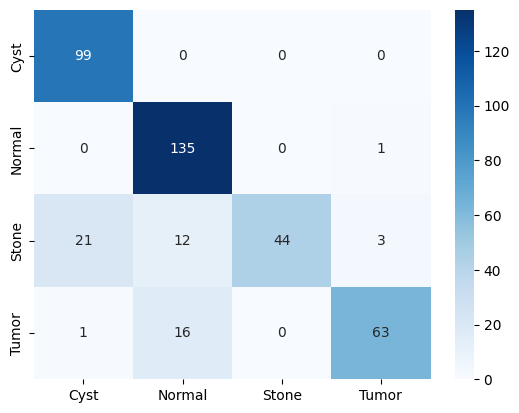

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [ ]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score:", auc_score)

# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:", dice_scores)

# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):", average_dsc)

Sensitivity (Recall): [1.         0.99264706 0.55       0.7875    ]
Specificity: [0.92567568 0.89189189 1.         0.98730159]
AUC Score: 0.9939618935207171
Dice Similarity Coefficient (DSC) for each class: [0.9        0.90301003 0.70967742 0.85714286]
Average Dice Similarity Coefficient (DSC): 0.842457577485628


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


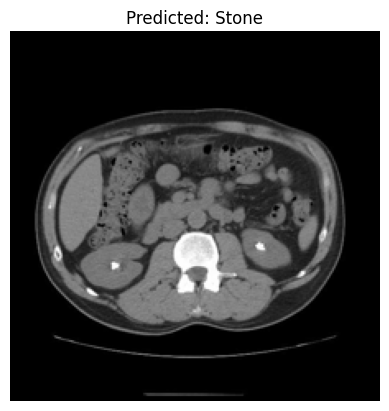

In [ ]:
### Evaluate on external Image
image_url = "https://prod-images-static.radiopaedia.org/images/24804/1af425ddaf16fa001b5d129ec2ecbb_big_gallery.jpeg"
load_predict_image_from_url(cnn_model,image_url)

## ResNet50

In [ ]:
resnet_base = ResNet50(weights='imagenet',include_top=False , input_shape=(225,225,3))

model_resnet=Sequential()
model_resnet.add(resnet_base)
model_resnet.add(Flatten())
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(4, activation='softmax'))

resnet_base.trainable=False

model_resnet.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       524,292 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,004 (91.98 MB)

 Trainable params: 524,292 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model_resnet.fit(train_generator,epochs=10,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.7976 - loss: 1.0841 - val_accuracy: 0.7169 - val_loss: 1.4048
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.8436 - loss: 0.8465 - val_accuracy: 0.8765 - val_loss: 0.4165
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.8769 - loss: 0.5976 - val_accuracy: 0.7922 - val_loss: 1.2219
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.8489 - loss: 0.8915 - val_accuracy: 0.8464 - val_loss: 0.4457
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.8494 - loss: 0.7991 - val_accuracy: 0.8705 - val_loss: 0.5543
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.8669 - loss: 0.7446 - val_accuracy: 0.5602 - val_loss: 4.8225
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.8126 - loss: 1.2639 - val_accuracy: 0.8102 - val_loss: 1.8785


In [ ]:
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.8326 - loss: 1.6678
Test Accuracy: 67.71%


### Evaluate ResNet50

In [ ]:
# Assuming you are using a test generator
y_pred_probs = model_resnet.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        Cyst       0.52      0.96      0.67        99
      Normal       0.76      0.89      0.82       136
       Stone       0.00      0.00      0.00        80
       Tumor       0.87      0.56      0.68        80

    accuracy                           0.66       395
   macro avg       0.54      0.60      0.54       395
weighted avg       0.57      0.66      0.59       395



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


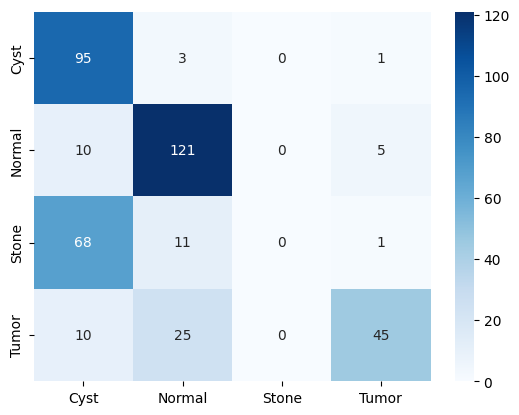

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [ ]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score:", auc_score)

# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:", dice_scores)

# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):", average_dsc)

Sensitivity (Recall): [0.95959596 0.88970588 0.         0.5625    ]
Specificity: [0.7027027  0.84942085 1.         0.97777778]
AUC Score: 0.946705182072829
Dice Similarity Coefficient (DSC) for each class: [0.67375887 0.81756757 0.         0.68181818]
Average Dice Similarity Coefficient (DSC): 0.5432861536584941


## VGG-16

In [ ]:
# Load VGG16 without the upper layers (fully connected layers)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(225, 225, 3))

#Build the Model
model_vgg = Sequential()
model_vgg.add(vgg_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(4, activation='softmax'))

# Freeze the base model layers to prevent them from being trained
vgg_base.trainable = False

model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model_vgg.fit(train_generator,epochs=15,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=5)])

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - accuracy: 0.5983 - loss: 1.0778 - val_accuracy: 0.7530 - val_loss: 0.7597
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.8416 - loss: 0.4160 - val_accuracy: 0.8735 - val_loss: 0.5329
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 0.9066 - loss: 0.2935 - val_accuracy: 0.8735 - val_loss: 0.4063
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9261 - loss: 0.2232 - val_accuracy: 0.8675 - val_loss: 0.3700
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9398 - loss: 0.1734 - val_accuracy: 0.8946 - val_loss: 0.3197
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.9709 - loss: 0.1185 - val_accuracy: 0.8795 - val_loss: 0.3263
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.9760 - loss: 0.0990 - val_accuracy: 0.9247 - val_loss: 0.2157
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9859 - loss: 0.0760 - val_accu

In [ ]:
test_loss, test_accuracy = model_vgg.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9753 - loss: 0.0797
Test Accuracy: 95.57%


### Evaluate VGG-16 model

In [ ]:

# Assuming you are using a test generator
y_pred_probs = model_vgg.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes  # Get actual labels from generator


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 619ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

        Cyst       0.90      0.98      0.94        99
      Normal       0.96      1.00      0.98       136
       Stone       0.99      0.86      0.92        80
       Tumor       0.99      0.93      0.95        80

    accuracy                           0.95       395
   macro avg       0.96      0.94      0.95       395
weighted avg       0.95      0.95      0.95       395



Confusion Matrix:


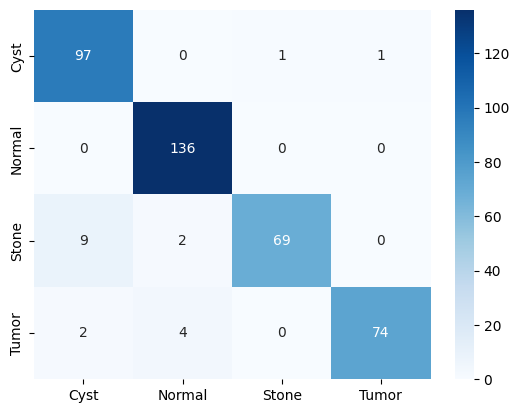

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [ ]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score:", auc_score)

Sensitivity (Recall): [0.97979798 1.         0.8625     0.925     ]
Specificity: [0.96283784 0.97683398 0.9968254  0.9968254 ]
AUC Score: 0.9945447232947233


In [ ]:
# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:", dice_scores)

# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):", average_dsc)

Dice Similarity Coefficient (DSC) for each class: [0.93719807 0.97841727 0.92       0.95483871]
Average Dice Similarity Coefficient (DSC): 0.94761351087433


In [ ]:
# loaded_model = keras.models.load_model('/content/drive/MyDrive/Models/kidney_model_vgg.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


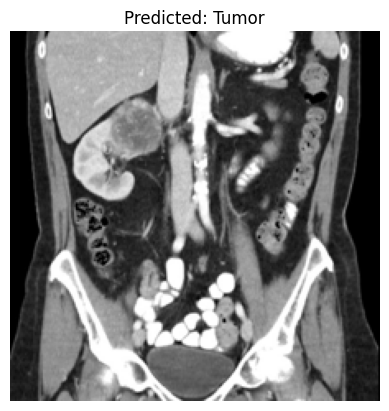

In [ ]:
image_url = "https://prod-images-static.radiopaedia.org/images/1270575/fb46b97485249baec54dde721f1719_big_gallery.jpg"
load_predict_image_from_url(model_vgg,image_url)

In [ ]:
# Save model
model_vgg.save('/content/drive/MyDrive/Models/model_vgg_lv.h5')

## MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(225, 225, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

model_mobNet = Model(inputs=base_model.input, outputs=output_layer)

model_mobNet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_mobNet.summary()

<ipython-input-53-16b7614d7ceb>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(225, 225, 3))


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 113, 113,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 113, 113,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 113, 113,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 113, 113,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 113, 113,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 113, 113,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 113, 113,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 113, 113,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 115, 115,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 57, 57,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 57, 57,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_mobNet.fit(train_generator,epochs=30,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=5)])

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.9115 - loss: 0.2555 - val_accuracy: 0.8042 - val_loss: 0.4908
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.9140 - loss: 0.2516 - val_accuracy: 0.8072 - val_loss: 0.4857
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.9107 - loss: 0.2375 - val_accuracy: 0.8283 - val_loss: 0.4615
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.9087 - loss: 0.2368 - val_accuracy: 0.8373 - val_loss: 0.4456
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - accuracy: 0.9148 - loss: 0.2246 - val_accuracy: 0.8313 - val_loss: 0.4534
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.9373 - loss: 0.1986 - val_accuracy: 0.8223 - val_loss: 0.4508
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.9382 - loss: 0.1981 - val_accuracy: 0.8313 - val_loss: 0.4272
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.9426 - loss: 0.1885 - val_accu

In [ ]:
test_loss, test_accuracy = model_mobNet.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9162 - loss: 0.2510
Test Accuracy: 83.07%


### Evaluate MobileNet

In [ ]:
# Assuming you are using a test generator
y_pred_probs = model_mobNet.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes  # Get actual labels from generator

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        Cyst       0.87      0.97      0.92        99
      Normal       0.72      0.96      0.82       136
       Stone       0.95      0.47      0.63        80
       Tumor       0.88      0.71      0.79        80

    accuracy                           0.81       395
   macro avg       0.86      0.78      0.79       395
weighted avg       0.84      0.81      0.80       395



Confusion Matrix:


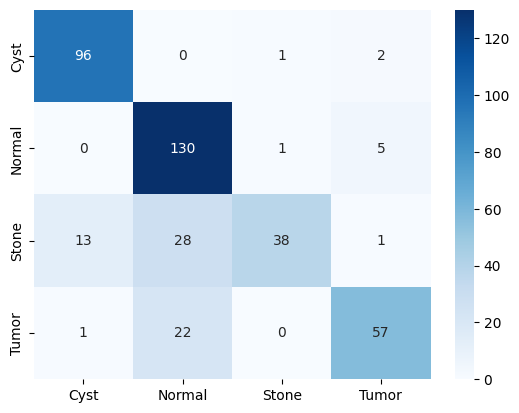

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [ ]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score:", auc_score)

Sensitivity (Recall): [0.96969697 0.95588235 0.475      0.7125    ]
Specificity: [0.9527027  0.80694981 0.99365079 0.97460317]
AUC Score: 0.9681237210281328


In [ ]:
# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:", dice_scores)

# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):", average_dsc)

Dice Similarity Coefficient (DSC) for each class: [0.91866029 0.82278481 0.63333333 0.7862069 ]
Average Dice Similarity Coefficient (DSC): 0.7902463317732449


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


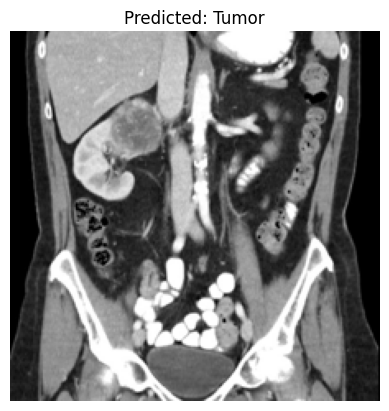

In [ ]:
image_url = "https://prod-images-static.radiopaedia.org/images/1270575/fb46b97485249baec54dde721f1719_big_gallery.jpg"
load_predict_image_from_url(model_mobNet,image_url)

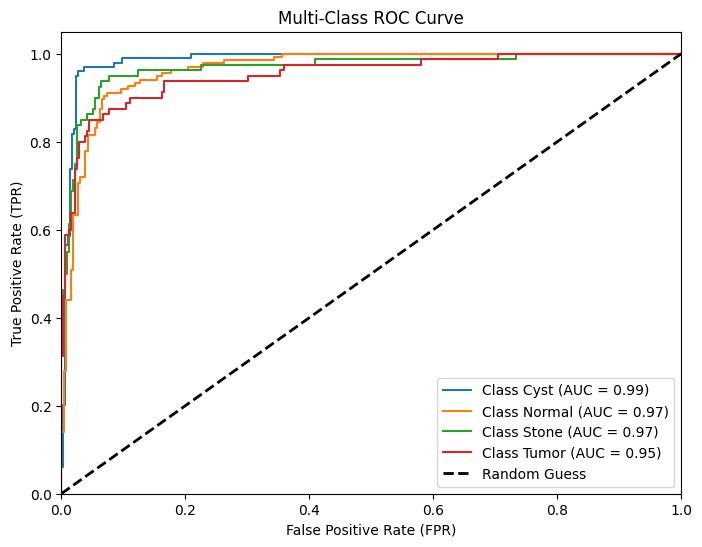

In [ ]:
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = len(test_generator.class_indices)

# Convert true labels to one-hot encoding
y_true_one_hot = np.eye(num_classes)[y_true]

# Initialize the plot
plt.figure(figsize=(8, 6))


class_labels = ["Cyst", "Normal", "Stone", "Tumor"]
# Loop through each class to calculate and plot ROC curve
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [ ]:
model_mobNet.save('/content/drive/MyDrive/Models/mobnet.h5')